# Connect Git with  Colab

In [2]:
# --- always get latest repo state in Colab ---
import os, sys, subprocess

REPO_URL  = "https://github.com/Wmeesena/Safe_Start.git"
REPO_ROOT = "/content/Safe_Start"     # repo root
WORKDIR   = os.path.join(REPO_ROOT, "MAGIC")
BRANCH    = "main"

def run(cmd):
    print("$", " ".join(cmd))
    subprocess.run(cmd, check=True)

if not os.path.isdir(REPO_ROOT):
    run(["git", "clone", "--depth", "1", "--branch", BRANCH, REPO_URL, REPO_ROOT])
else:
    run(["git", "-C", REPO_ROOT, "fetch", "origin"])
    run(["git", "-C", REPO_ROOT, "checkout", BRANCH])
    run(["git", "-C", REPO_ROOT, "reset", "--hard", f"origin/{BRANCH}"])


# Set working dir and import path
os.chdir(WORKDIR if os.path.isdir(WORKDIR) else REPO_ROOT)
if REPO_ROOT not in sys.path:
    sys.path.append(REPO_ROOT)

print("CWD:", os.getcwd())
!git -C {REPO_ROOT} rev-parse --abbrev-ref HEAD
!git -C {REPO_ROOT} rev-parse HEAD

# installs
%pip install -q ucimlrepo


$ git clone --depth 1 --branch main https://github.com/Wmeesena/Safe_Start.git /content/Safe_Start
CWD: /content/Safe_Start/MAGIC
main
37a94136bd8a479db4d86509339f2f4cf585287e


# Setup

In [3]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import torch
from src.models.mlp import MLP
import torch.nn as nn
import torch.optim as optim
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from src.train import pretrain,  joint_train, train_all, fit_dt
from src.eval import evaluate_avg_accuracy, evaluate_robust, eval_one, eval_all, print_last_bias_mlp
from src.utils import pct, pct_ci
from src.plots import plot_loss_multi, plot_all_loss
from src.data import load_magic_data

# %load_ext autoreload
# %autoreload 2


# Data

In [ ]:
# Hyperparameters for checking on local
SIGMA = 10.0
SAMPLES_EVAL = 1
SAMPLES_TRAIN = 1
GAMMA = 1000.
NUM_EPOCHS = 1
NUM_EPOCHS_PRE = 1
SAFE_BIAS = 1.0

In [48]:
# Hyperparameters for running on colab
SIGMA = .2
SAMPLES_EVAL = 500000
SAMPLES_TRAIN = 100000
GAMMA = 20000.
NUM_EPOCHS = 100
NUM_EPOCHS_PRE = 2000
SAFE_BIAS = 1.0
BATCH_SIZE = 1024

In [5]:
X_train, y_train, X_test, y_test = load_magic_data()

In [6]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train class balance:", dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print("Test  class balance:", dict(zip(unique, counts)))

Train class balance: {np.float32(0.0): np.int64(4879), np.float32(1.0): np.int64(9121)}
Test  class balance: {np.float32(0.0): np.int64(1809), np.float32(1.0): np.int64(3211)}


# Pretrain

In [7]:
# init_model = MLP(input_size=X_train.shape[1]).to(device)

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLP(input_size=X_train.shape[1]).to(device)
pre_model = pretrain(X_train,y_train, model, num_epochs=NUM_EPOCHS_PRE)
init_model = MLP(input_size=X_train.shape[1]).to(device)

Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d79c6b88fe0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d79c6b88fe0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

In [45]:
_ = eval_one(
    pre_model, X_test, y_test,
    sigma=SIGMA, SAMPLES_EVAL=SAMPLES_EVAL,
    J_chunk=5000,        # <= keep m small
    N_chunk=512,      # <= keep B small
    B=300             # <= lighter bootstrap
)


Accuracy: 87.29%  (CI 95%: [86.34%, 88.18%])
Robust Accuracy: 67.81514%  (CI 95%: [67.36317%, 68.34079%])
Conditional Robust Accuracy: 71.89072%  (CI 95%: [71.47422%, 72.34891%])


In [23]:
print_last_bias_mlp(pre_model)

fc_last.bias shape: (1,)
[1.0278024673461914]


# Check Data Topology: Random Forest

One single split can lead to $73\%$ accuracy.

In [8]:
# # 1) Decision stump (single split)
# acc1, stump = fit_dt("Decision stump (max_depth=1)",X_train,y_train,X_test,y_test,  max_depth=1)

# # quick confusion matrix for the stump
# cm = confusion_matrix(y_test, stump.predict(X_test))
# print("\nConfusion matrix (stump):")
# pprint(cm)


# Training

In [53]:
SIGMA

0.7

In [82]:
configs = [ ("safe", "sgd")  ]
# configs = [ ("naive", "sgd") ,("safe", "sgd"), ("safe_neg", "sgd")  ]

results = train_all(X_train, y_train,pre_model, 50, GAMMA, SAMPLES_TRAIN, SIGMA, configs = configs , SAFE_BIAS=15.0, lr=1e-7, batch_size = BATCH_SIZE )


Training safe with sgd...


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[epoch 000000001] loss=13537.525390625 | avg=3.760837555 | rare=1.353376465
[epoch 000000002] loss=13472.713797433 | avg=3.771247659 | rare=1.346894247
[epoch 000000003] loss=7337.389630999 | avg=4.169492790 | rare=0.733322022


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d79c6b88fe0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d79c6b88fe0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[epoch 000000004] loss=1234.411577497 | avg=4.276551485 | rare=0.123013504
[epoch 000000005] loss=1343.972582136 | avg=3.991677914 | rare=0.133998094
[epoch 000000006] loss=1297.838322231 | avg=3.833367143 | rare=0.129400495
[epoch 000000007] loss=1299.304818290 | avg=3.666562234 | rare=0.129563825
[epoch 000000008] loss=1308.405508859 | avg=3.504117285 | rare=0.130490140
[epoch 000000009] loss=1367.474984305 | avg=3.324980821 | rare=0.136415001
[epoch 000000010] loss=1286.503112793 | avg=3.280320099 | rare=0.128322278
[epoch 000000011] loss=1264.153189523 | avg=3.142153859 | rare=0.126101100
[epoch 000000012] loss=1162.577484131 | avg=3.141674621 | rare=0.115943580
[epoch 000000013] loss=1065.316663470 | avg=3.137246660 | rare=0.106217942
[epoch 000000014] loss=1094.430284773 | avg=3.001709495 | rare=0.109142859
[epoch 000000015] loss=1048.217729841 | avg=2.970767140 | rare=0.104524697
[epoch 000000016] loss=1060.242170061 | avg=2.877506171 | rare=0.105736467
[epoch 000000017] loss=10

# Results

## Loss Trajectories

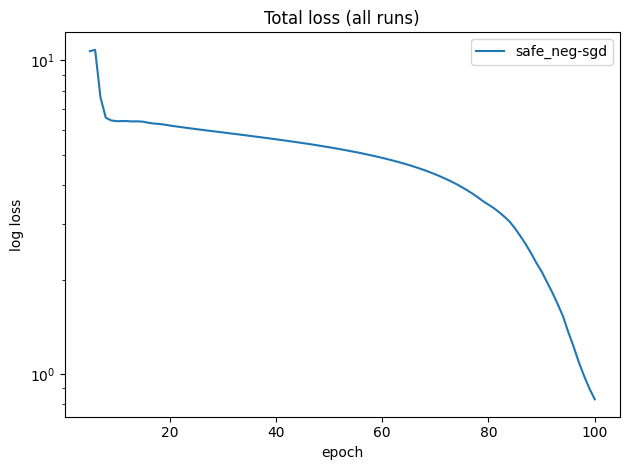

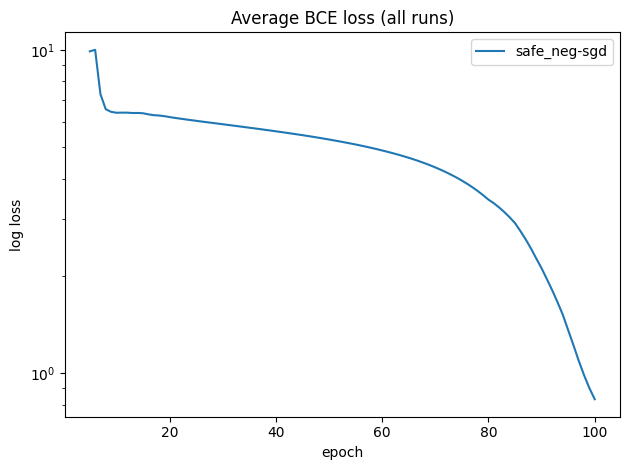

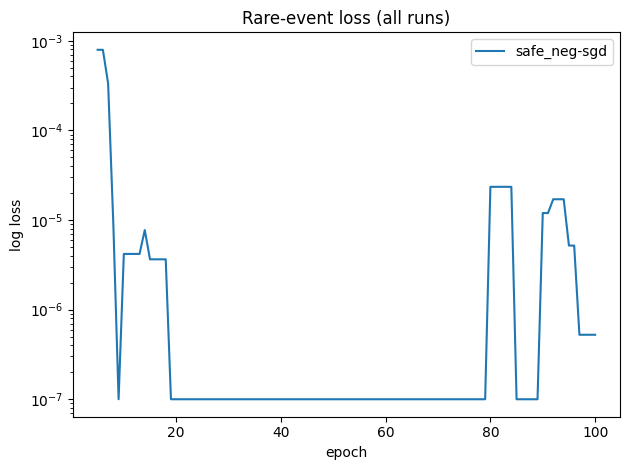

In [ ]:
plot_all_loss(results, show_log=True)

## Accuracies

In [84]:
for config in configs:
    print(f"Evaluating config: {config}")
    _ = eval_one(
        results[config][0], X_test, y_test,
        sigma=SIGMA, SAMPLES_EVAL=SAMPLES_EVAL,
        J_chunk=5000,        # <= keep m small
        N_chunk=512,      # <= keep B small
        B=300             # <= lighter bootstrap
    )
    print("-------------------------------------")

Evaluating config: ('safe', 'sgd')
Accuracy: 80.02%  (CI 95%: [78.89%, 81.10%])
Robust Accuracy: 80.07731%  (CI 95%: [79.15045%, 80.98284%])
Conditional Robust Accuracy: 98.04506%  (CI 95%: [97.81800%, 98.26147%])
-------------------------------------
